Markov state model for penta peptide
=====


In [1]:
import pyemma
pyemma.__version__

'1.2-379-g0df1e17-dirty'

This notebook has been tested for version 1.2.2. If you are using a different version some adaptations may be required.

Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


Now we import the pyEMMA modules required for the following steps.

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl
from pyemma import config

WW-pentapeptide - load data
------

We first have to load the PDB file and the trajectory data, in this case for WW-pentapeptide.

In [4]:
indir = './data'
topfile =  indir+'/init-ww-penta.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('-protein.xtc'):
        traj_list.append(os.path.join(indir,filename))

We can decide here which features we would like to use in the further analysis. In this case backbone torsions. As we want to do TICA on those coordinates, which requires subtracting the mean from each feature, we cannot use angles directly but have to transform them into a space where an arithmetic mean can be computed. We are using the cos/sin transform to do this.

In [5]:
feat = coor.featurizer(topfile)
feat.add_backbone_torsions(cossin=True)
# describe the features
feat.describe()

['COS(PHI 0 LEU 2 )',
 'SIN(PHI 0 LEU 2 )',
 'COS(PHI 0 ALA 3 )',
 'SIN(PHI 0 ALA 3 )',
 'COS(PHI 0 LEU 4 )',
 'SIN(PHI 0 LEU 4 )',
 'COS(PHI 0 LEU 5 )',
 'SIN(PHI 0 LEU 5 )',
 'COS(PHI 0 TRP 1 )',
 'SIN(PHI 0 TRP 1 )',
 'COS(PHI 0 LEU 2 )',
 'SIN(PHI 0 LEU 2 )',
 'COS(PHI 0 ALA 3 )',
 'SIN(PHI 0 ALA 3 )',
 'COS(PHI 0 LEU 4 )',
 'SIN(PHI 0 LEU 4 )']

Now we define the source of input coordinates (we don't load them into memory at this stage - they will be loaded as needed). Compute a few basic data statistics gives:

In [6]:
inp = coor.source(traj_list, feat)
print 'number of trajectories = ',inp.number_of_trajectories()
print 'trajectory length = ',inp.trajectory_length(0)
print 'number of dimension = ',inp.dimension()

number of trajectories =  25
trajectory length =  5001
number of dimension =  16


#TICA and clustering 

For TICA we have to choose a *lag* time and we have to define the output dimension. This can be either set by the *dim* keyword, or by specify a percentage the kinetic variance we want to keep. Here we choose 90%, which gives us three dimensions. From the original 16-dimensional space, most of the relevant kinetic information is in a three-dimensional subspace

In [7]:
tica_obj = coor.tica(inp, lag=20, var_cutoff=0.9)
print 'TICA dimension', tica_obj.dimension()

2015-07-21 20:46:43,825 coordinates.transform.TICA[1] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-21 20:46:43,826 coordinates.transform.TICA[1] INFO     Running TICA with tau=20; Estimating two covariance matrices with dimension (16, 16)


TICA dimension 3


We can have a look at the cumulative kinetic variance, which is similar to the cumulative variance in PCA. The first dimension explaines 38% of the variance in the data, the first two explain 75% and the first three explain nearly 95%.

In [8]:
tica_obj.cumvar

array([ 0.38527381,  0.75235544,  0.94326229,  0.9926726 ,  0.99931903,
        0.99950935,  0.9996539 ,  0.99974701,  0.9998262 ,  0.9998814 ,
        0.99992397,  0.99996192,  0.99997767,  0.99998953,  0.99999636,  1.        ])

In [9]:
# here we do a little trick to ensure that eigenvectors always have the same sign structure. 
# That's irrelevant to the analysis and just nicer plots - you can ignore it.
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0: 
        tica_obj.eigenvectors[:, i] *= -1

Now we get the TICA output, i.e. the coordinates after being transformed to the three slowest components. You can think of this as a low-dimensional space of good reaction coordinates. 
Having a look at the shape of the output reveals that we still have 25 trajectories, each of length 5001, but now only three dimensions.

In [10]:
Y = tica_obj.get_output() # get tica coordinates
print np.shape(Y)

(25, 5001, 3)


Note that at this point we loaded the compressed coordinates into memory. We don't have to do this, but it will significantly speed up any further analysis. It is also easy because it's low-dimensional. In general, after the TICA-transformation we can often keep the data in memory even if we are working with massive data of a large protein. 

Now we look at the distribution on the two dominant TICA coordinates (three are hard to visualize). For that, we build a histogram of the first two TICA dimensions and then compute a free energy by taking
$F_i = -\ln z_i$, where $z_i$ is the number of bin counts.

In [11]:
def plot_labels():
    text(-0.3, -8.4, '1', fontsize=20, color='black')
    text(0.1, -6.8, '2', fontsize=20, color='black')
    text(6.7, 0.5, '3', fontsize=20, color='black')
    text(-0.3, 0, '4', fontsize=20, color='white')    

/Users/noe/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


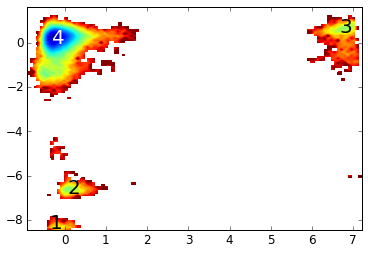

In [12]:
# stack all trajectories
all_data = np.vstack(Y)
# histogram data
z,x,y = np.histogram2d(all_data[:,0], all_data[:,1], bins=100)
# compute free energies
F = -np.log(z)
# do a contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 100, extent=extent)
plot_labels()

Let's have a look how one of the trajectories looks like in the space of the first three TICA components. We can see that the TICA components nicely resolve the slow transitions as discrete jumps.

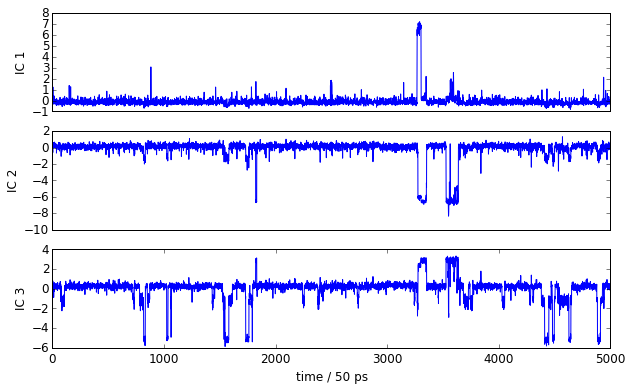

In [13]:
figure(figsize(10,6))
ax1=plt.subplot(311)
plot(Y[0][:,0]); ylabel('IC 1'); xticks([]); #yticks([0,2,4,6])
ax1=plt.subplot(312)
plot(Y[0][:,1]); ylabel('IC 2'); xticks([]); #yticks([-6, -4, -2, 0])
ax1=plt.subplot(313)
plot(Y[0][:,2]); xlabel('time / 50 ps'); ylabel('IC 3'); #yticks([-2,0,2,4])

The TICA coordinates are now clustered into a number of discrete states using the k-means algorithm. The k-means algorithm requires as input the number of clusters *n_clusters*. For the metric there is only one choice possible here which is *euclidean*.

In [14]:
n_clusters = 100      # number of k-means clusters

In [15]:
clustering = coor.cluster_kmeans(Y,k=n_clusters)

2015-07-21 20:37:05,501 coordinates.clustering.KmeansClustering[2] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-21 20:37:06,611 coordinates.clustering.KmeansClustering[2] INFO     Accumulated all data, running kmeans on (125025, 3)
2015-07-21 20:37:07,645 coordinates.clustering.KmeansClustering[2] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


The trajectories are now assigned to the cluster centers.

In [16]:
dtrajs = clustering.dtrajs

In order to analyze the distribution of the data to the cluster centers we make a histogram of the discrete trajectories and analyze the distribution of the clustercenters in 2-dimensional TICA space.

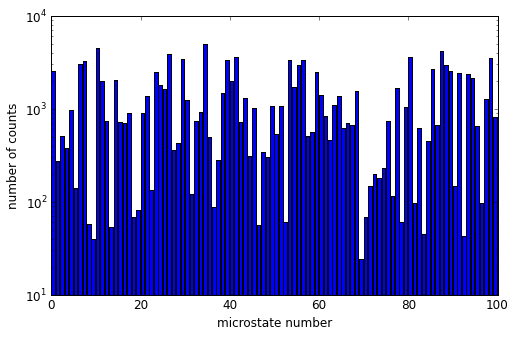

In [35]:
figure(figsize(8, 5))
histogram = np.bincount(np.concatenate(dtrajs), minlength=len(clustering.clustercenters));
ind = np.arange(len(histogram))
plt.bar(ind, histogram, log=True)
plt.xlabel('microstate number')
plt.ylabel('number of counts')

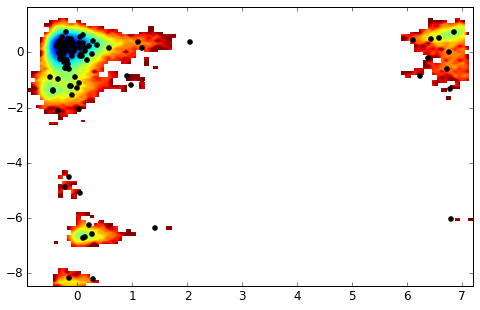

In [36]:
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
contourf(F.T, 100, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

The states are well distributed in phase space.

#Implied timescales

Here we calculate the implied timescales at a series of lagtimes defined in the *lags[ ]* array. Instead of an array you can just give a single number such as lags=100 in order to generate a range of lagtimes <= 100.

In [37]:
lags = [1,2,5,10,15,20,30,50]
its = msm.ImpliedTimescales(dtrajs, lags=lags, nits=5)

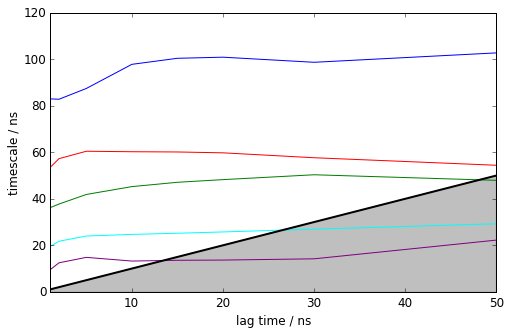

In [38]:
mpl.plot_implied_timescales(its, ylog=False, units='ns')
ylim(0, 120);

Error bars for the implied timescales can be obtained by bootstrapping.

In [39]:
its.bootstrap(nsample=25)

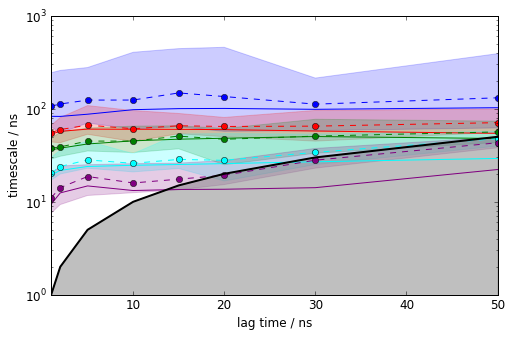

In [40]:
mpl.plot_implied_timescales(its, ylog=True, units='ns')
ylim(1,1000);

It can be seen that the timescales are approximately constant within the error. Below we will select a lag time of 20 ns to build a Markov model

Estimate MSM
===========

Based on the implied timescales we determine a suitable lagtime *msm_lag* to estimate the MSM. 

In [23]:
msm_lag = 20
M = msm.estimate_markov_model(dtrajs, msm_lag)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  1.0
fraction of counts used =  1.0


From the MSM which is now stored in the object we called *M* various properties can be obtained. We start by analyzing the free energy computed over the first two TICA coordinates

In [24]:
# This will compute the free energies by MSM state. Very often we will use this quantity, 
# however this is not so nice to produce a contour plot...
F_pi = -np.log(M.stationary_distribution)  

In [25]:
# ... therefore we take the statistical weight of each simulation timestep (also available from the MSM object)
# and use that to create a contour plot
xall = np.vstack(Y)[:,0]
yall = np.vstack(Y)[:,1]
W = np.concatenate(M.trajectory_weights())
# compute free energies
Fall = -np.log(W)
Fall -= np.min(Fall)

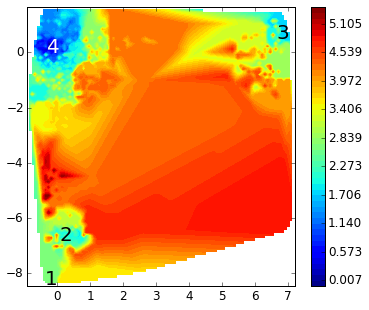

In [26]:
fig = plt.figure(figsize=(6,5))
mpl.contour(xall, yall, Fall)
plot_labels()

Now we analyze the slowest processes by looking at the distribution of states along the first 3 eigenvectors.

In [27]:
# project eigenvectors
proj_ev1_all = np.hstack([M.eigenvectors_right()[:,1][dtraj] for dtraj in M.discrete_trajectories_full])
proj_ev2_all = np.hstack([M.eigenvectors_right()[:,2][dtraj] for dtraj in M.discrete_trajectories_full])
proj_ev3_all = np.hstack([M.eigenvectors_right()[:,3][dtraj] for dtraj in M.discrete_trajectories_full])

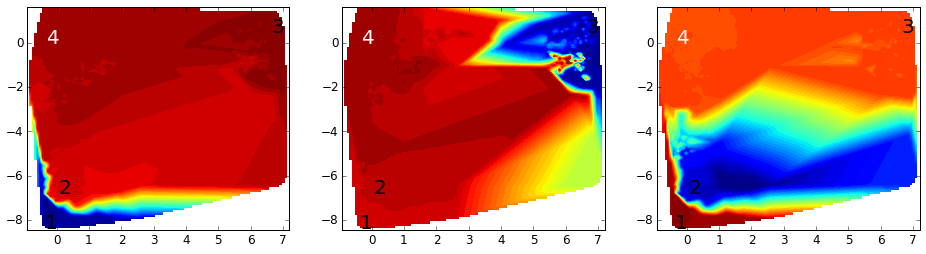

In [29]:
fig = plt.figure(figsize=(16,4))

ax1=plt.subplot(131)
r2 = M.eigenvectors_right()[:,1]
ax1 = mpl.contour(xall, yall, proj_ev1_all, method='linear', colorbar=False)
plot_labels()

ax2=plt.subplot(132)
r3 = M.eigenvectors_right()[:,2]
ax2 = mpl.contour(xall, yall, proj_ev2_all, method='linear', colorbar=False)
plot_labels()

ax3=plt.subplot(133)
r4 = M.eigenvectors_right()[:,3]
ax3 = mpl.contour(xall, yall, -proj_ev3_all, method='linear', colorbar=False)
plot_labels()

PCCA
==

Next the MSM is coarse grained into a user-defined number of macrostates (*n_sets*).

In [30]:
n_sets = 4
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership=M.metastable_memberships  # get PCCA memberships
# memberships over trajectory
mem1_all = np.hstack([membership[:,0][dtraj] for dtraj in M.discrete_trajectories_full])
mem2_all = np.hstack([membership[:,1][dtraj] for dtraj in M.discrete_trajectories_full])
mem3_all = np.hstack([membership[:,2][dtraj] for dtraj in M.discrete_trajectories_full])
mem4_all = np.hstack([membership[:,3][dtraj] for dtraj in M.discrete_trajectories_full])

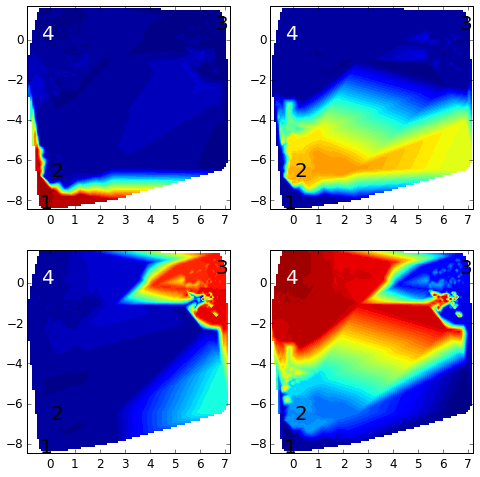

In [31]:
fig = plt.figure(figsize=(8,8))

ax1 = plt.subplot(221)
ax1 = mpl.contour(xall, yall, mem1_all, zlim=[0,1], method='linear', colorbar=False)
plot_labels()

ax2 = plt.subplot(222)
ax2 = mpl.contour(xall, yall, mem2_all, zlim=[0,1], method='linear', colorbar=False)
plot_labels()

ax3 = plt.subplot(223)
ax3 = mpl.contour(xall, yall, mem3_all, zlim=[0,1], method='linear', colorbar=False)
plot_labels()

ax4 = plt.subplot(224)
ax4 = mpl.contour(xall, yall, mem4_all, zlim=[0,1], method='linear', colorbar=False)
plot_labels()

For each macrostate we can generate a number of representative sample structures and store them into a trajectory file.

In [32]:
pcca_samples = M.sample_by_distributions(pcca_dist, 10)

In [33]:
coor.save_trajs(inp, pcca_samples, outfiles=['./data/pcca1_10samples.xtc','./data/pcca2_10samples.xtc',
                                             './data/pcca3_10samples.xtc','./data/pcca4_10samples.xtc'])

2015-07-21 20:39:01,336 coordinates.api INFO     Created file ./data/pcca1_10samples.xtc
2015-07-21 20:39:01,769 coordinates.api INFO     Created file ./data/pcca2_10samples.xtc
2015-07-21 20:39:02,227 coordinates.api INFO     Created file ./data/pcca3_10samples.xtc
2015-07-21 20:39:02,666 coordinates.api INFO     Created file ./data/pcca4_10samples.xtc


['./data/pcca1_10samples.xtc',
 './data/pcca2_10samples.xtc',
 './data/pcca3_10samples.xtc',
 './data/pcca4_10samples.xtc']

Structure figures are generated with VMD, pyMol or another visualization program of your choice. Here we used VMD to generate the following structures, corresponding to the four metastable states:

<table>
<tr>
<td>PCCA set 1</td>
<td>PCCA set 2</td>
<td>PCCA set 3</td>
<td>PCCA set 4</td>
</tr>
<tr>
<td><img src='./data/pcca1_10samples.png', width=200></td>
<td><img src='./data/pcca2_10samples.png', width=200></td>
<td><img src='./data/pcca3_10samples.png', width=200></td>
<td><img src='./data/pcca4_10samples.png', width=200></td>
</tr>
</table>